In [1]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib notebook
import os

In [2]:
from IPython.display import display, HTML

In [3]:
#Event dataframe anlegen zur späteren Auswertung der An/Abschaltevents
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index' ,'Ladevorgang', 'Status', 'Ladeleistung','minuten_index_Abschaltung','timestamp_abschalt'])

#iteration über alle Phasen
for Phase in range (1,4):
    #Einlesen der aktuellen .csv einer Phase
    P_Phase = pd.read_csv('power_today_minute_'+str(Phase)+'.csv', names = ['timestamp','P'])
    Phase_mit_delta = P_Phase
    Phase_mit_delta['P_delta'] = 0
    Leerlaufleistung_Phase = P_Phase[0:100]['P'].mean()
    
    #Iteration über alle Werte dieser Phase
    for row in range(1,len(P_Phase)):
        # daten import
        Timestamp = P_Phase.iloc[row]['timestamp']
        minuten_index = row
        P_new = P_Phase.iloc[row]['P']
        P_old = P_Phase.iloc[row-1]['P']
        P_delta = P_new-P_old
        Phase_mit_delta.loc[row, 'P_delta'] = P_delta
        Phase_mit_delta.to_csv('test' + str(Phase) + '.csv')

        ### Einschaltvorgang dedektieren ###
        # ist delta P relevant
        if(P_delta > 400.0):
            # Prüfen ob Ladenvorgang beginnt/beendet
            #Wenn delta P positiv ---> event kreieren um später zu checken ob es ein Einschaltvorgang war
            Event_df.loc[len(Event_df)]= [Timestamp, Phase, minuten_index, 'ein', 'not checked', 0,0,0]

        #Check events: Überprüfen ob vorher eingetragenes event wirklich ein Einschaltvorgang ist
        for row_event in range(0,len(Event_df)):
            #condition to check event
            minuten_index_event = Event_df.iloc[row_event]['minuten_index']
            #Check auf Einschaltvorgang
            if ((minuten_index_event+3 == minuten_index) & 
                (Event_df.iloc[row_event]['Ladevorgang'] == 'ein') &
                (Event_df.iloc[row_event]['Phase'] == Phase)):
                Ladeleistung = P_Phase.iloc[minuten_index_event+3]['P'] - P_Phase.iloc[minuten_index_event-3]['P'] 
                sum_delta_P = Phase_mit_delta[minuten_index_event:minuten_index_event+3]['P_delta'].sum()
                deviation = abs(Ladeleistung-sum_delta_P)/Ladeleistung 
                if deviation > 0.1:
                    Event_df = Event_df.drop(row_event)
                else:
                    Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', Ladeleistung]
        
        ### Ausschaltvorgang dedektieren ###
        #Checken ob aktuelle Leistung das Ende eines Einschaltvorgangs impliziert        
        if (('ein' in Event_df['Ladevorgang'].unique()) &
           ('checked' in Event_df['Status'].unique())):
            # create df with charging status on
            only_load_event_df = Event_df[Event_df['Ladevorgang'] == 'ein']
            #Soll Leistung = Leistung die auf der Phase anliegen sollte, wenn alle zuvor ladenden Autos noch an der Phase hängen würden
            Soll_Leistung = Leerlaufleistung_Phase + Event_df[(Event_df['Ladevorgang']=='ein') & 
                                                              (Event_df['minuten_index'] <= minuten_index) & 
                                                              (Event_df['minuten_index_Abschaltung'] == 0) & 
                                                              (Event_df['Phase'] == Phase)]['Ladeleistung'].sum()
            #Aktuelle Leistung (neuer Messwert)
            Ist_Leistung = P_new 
            #Residuale Leistung 
            P_residual = Soll_Leistung - Ist_Leistung
            #Überprüfen ob fehlende Leistung (P_residual) zu einem zuvor ladenden Auto passt
            only_load_event_df['deviation_P'] = only_load_event_df['Ladeleistung'].apply(lambda ladeleistung_auto: abs(ladeleistung_auto-P_residual)/
                                                                                         ladeleistung_auto)
            if ((only_load_event_df['deviation_P'] < 0.03).any()):
                # sort load events by size
                # und nehme das erste Event, was der aktuellen leistung am nächsten ist
                charg_off_ev_index = only_load_event_df['deviation_P'].sort_values().index[0]
                Event_df.loc[charg_off_ev_index,['minuten_index_Abschaltung']] = minuten_index
                Event_df.loc[charg_off_ev_index,['timestamp_abschalt']] = Timestamp
                Event_df.loc[charg_off_ev_index, ['Ladevorgang']] = 'aus'

/Users/markus/anaconda/envs/ev_project/lib/python3.5/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Alter Code     
        for charge in range(0, len(Event_df)):
            if ((Event_df.iloc[charge]['Ladevorgang'] == 'ein') & 
                (Event_df.iloc[charge]['minuten_index_Abschaltung'] == 0)):
                Ladeleistung_auto = Event_df.iloc[charge]['Ladeleistung']
                deviation_P = (abs(Ladeleistung_auto-P_residual)/Ladeleistung_auto)
                if ((deviation_P < 0.02)):
                        Event_df.loc[charge,['minuten_index_Abschaltung']] = minuten_index
                        Event_df.loc[charge,['timestamp_abschalt']] = Timestamp
                        einschaltvorgang_gefunden = 1
                        Event_df.loc[charge, ['Ladevorgang']] = 'aus'
                        #print(deviation_P)
                        #print('tada')

In [4]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.505390e+09,1,834,aus,checked,3590,1217,1.50541e+09
1,1.505392e+09,1,860,aus,checked,3630,1023,1.5054e+09
2,1.505393e+09,1,888,aus,checked,3438,968,1.5054e+09
3,1.505377e+09,2,621,aus,checked,3528,1154,1.50541e+09
4,1.505390e+09,2,841,aus,checked,3617,974,1.5054e+09
5,1.505393e+09,2,885,aus,checked,3496,1065,1.5054e+09
6,1.505378e+09,3,640,aus,checked,3497,694,1.50538e+09
7,1.505386e+09,3,763,aus,checked,3496,947,1.5054e+09
8,1.505386e+09,3,772,aus,checked,3464,1102,1.50541e+09
9,1.505390e+09,3,832,aus,checked,3505,931,1.5054e+09


In [5]:
Event_df = Event_df.sort_values('timestamp')
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
3,1.505377e+09,2,621,aus,checked,3528,1154,1.50541e+09
6,1.505378e+09,3,640,aus,checked,3497,694,1.50538e+09
7,1.505386e+09,3,763,aus,checked,3496,947,1.5054e+09
8,1.505386e+09,3,772,aus,checked,3464,1102,1.50541e+09
9,1.505390e+09,3,832,aus,checked,3505,931,1.5054e+09
0,1.505390e+09,1,834,aus,checked,3590,1217,1.50541e+09
4,1.505390e+09,2,841,aus,checked,3617,974,1.5054e+09
1,1.505392e+09,1,860,aus,checked,3630,1023,1.5054e+09
10,1.505392e+09,3,871,aus,checked,3439,905,1.50539e+09
5,1.505393e+09,2,885,aus,checked,3496,1065,1.5054e+09


In [6]:
# Zusammenfassen von mehrphasigen Ladevorängen
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Ladeleistung','Ladevorgang_ende'])


for events in range(0,len(Event_df)):
    timestamp = Event_df.iloc[events]['timestamp']
    timestamp_abschaltung = Event_df.iloc[events]['timestamp_abschalt']
    Phase = []
    Ladeleistung = []
    same_events = Event_df.loc[Event_df['timestamp'] == Event_df.iloc[events]['timestamp']]
    event_count = len(same_events)
    for a in range (0,event_count):
        Phase.append(same_events.iloc[a]['Phase'])
        Ladeleistung.append(str(same_events.iloc[a]['Phase'])+': '+str(same_events.iloc[a]['Ladeleistung']))
    if (len(ladevorgang_df.loc[ladevorgang_df['timestamp_start'] == timestamp]) !=1):
        ladevorgang_df.loc[len(ladevorgang_df)]= [timestamp, Phase, Ladeleistung, timestamp_abschaltung]
ladevorgang_df

,timestamp_start,Phasen,Ladeleistung,Ladevorgang_ende
0,1.505377e+09,[2],[2: 3528.0],1.505409e+09
1,1.505378e+09,[3],[3: 3497.0],1.505382e+09
2,1.505386e+09,[3],[3: 3496.0],1.505397e+09
3,1.505386e+09,[3],[3: 3464.0],1.505406e+09
4,1.505390e+09,[3],[3: 3505.0],1.505396e+09
5,1.505390e+09,[1],[1: 3590.0],1.505413e+09
6,1.505390e+09,[2],[2: 3617.0],1.505398e+09
7,1.505392e+09,[1],[1: 3630.0],1.505401e+09
8,1.505392e+09,[3],[3: 3439.0],1.505394e+09
9,1.505393e+09,[2],[2: 3496.0],1.505404e+09


<IPython.core.display.Javascript object>


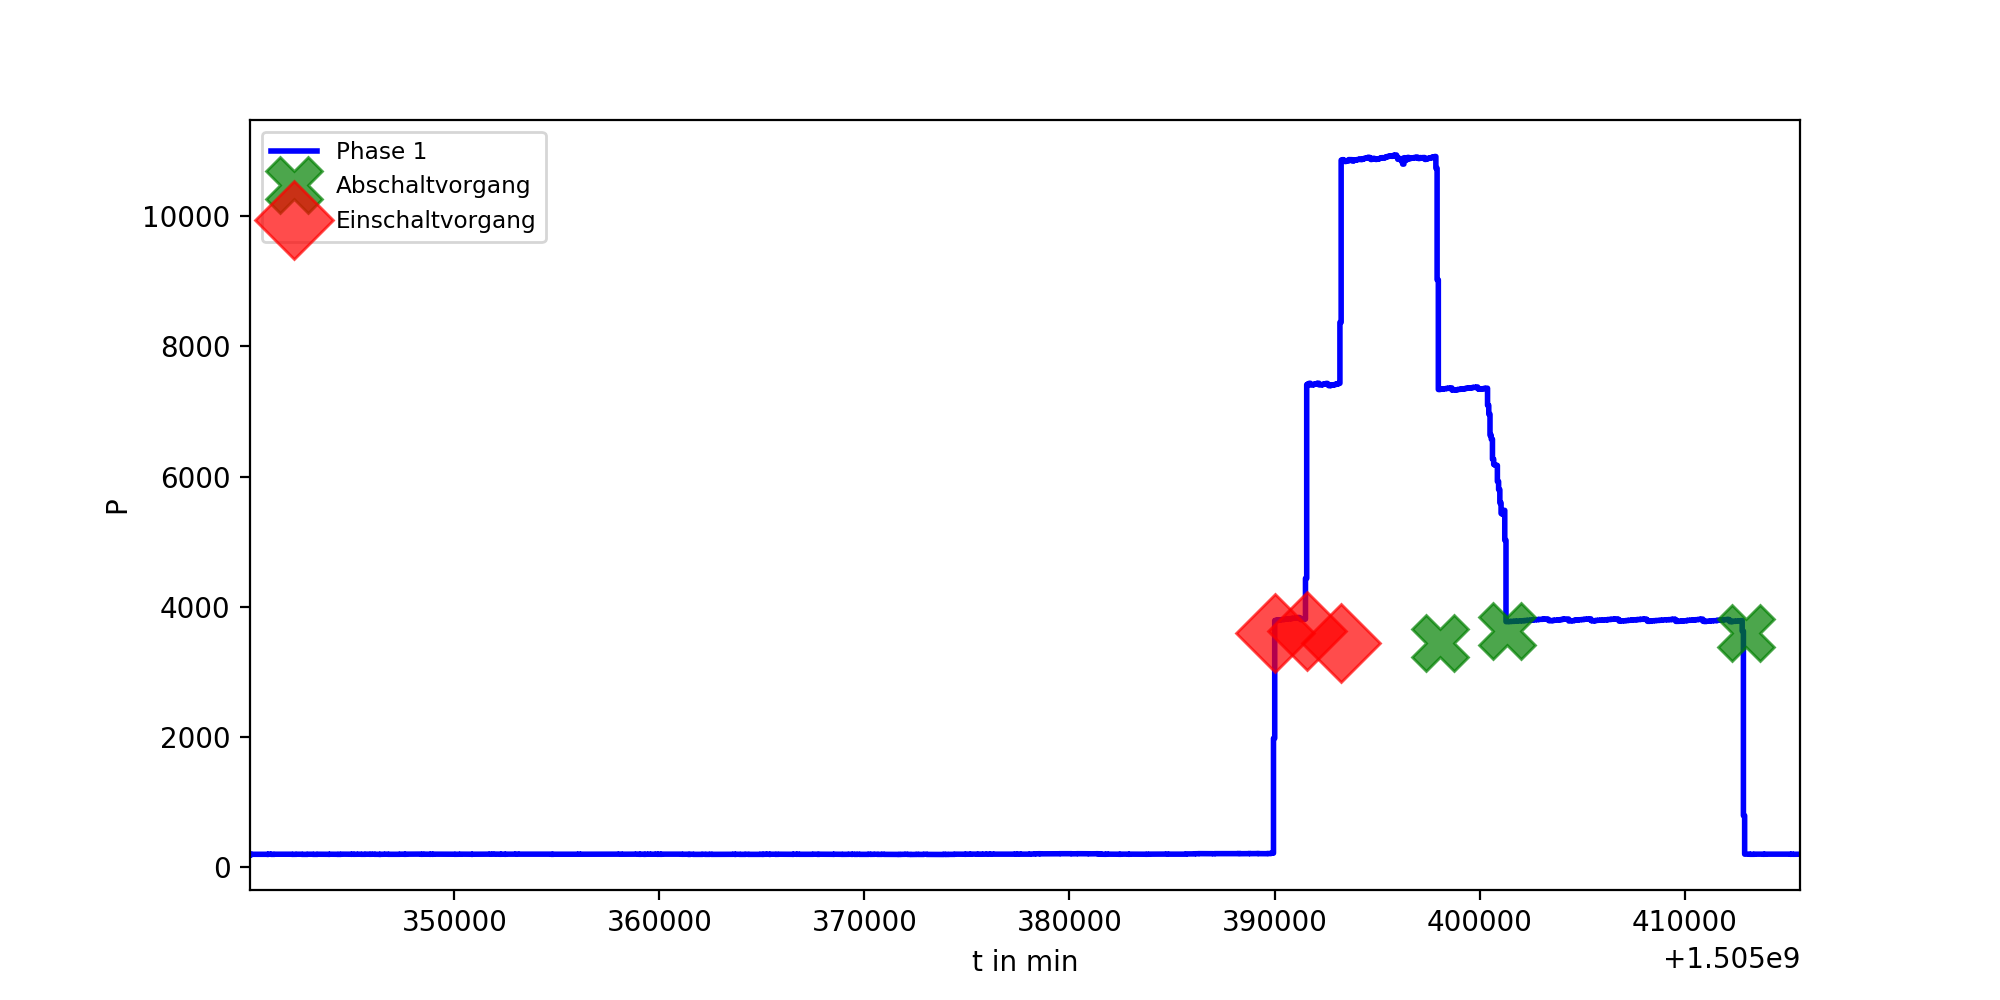

<IPython.core.display.Javascript object>


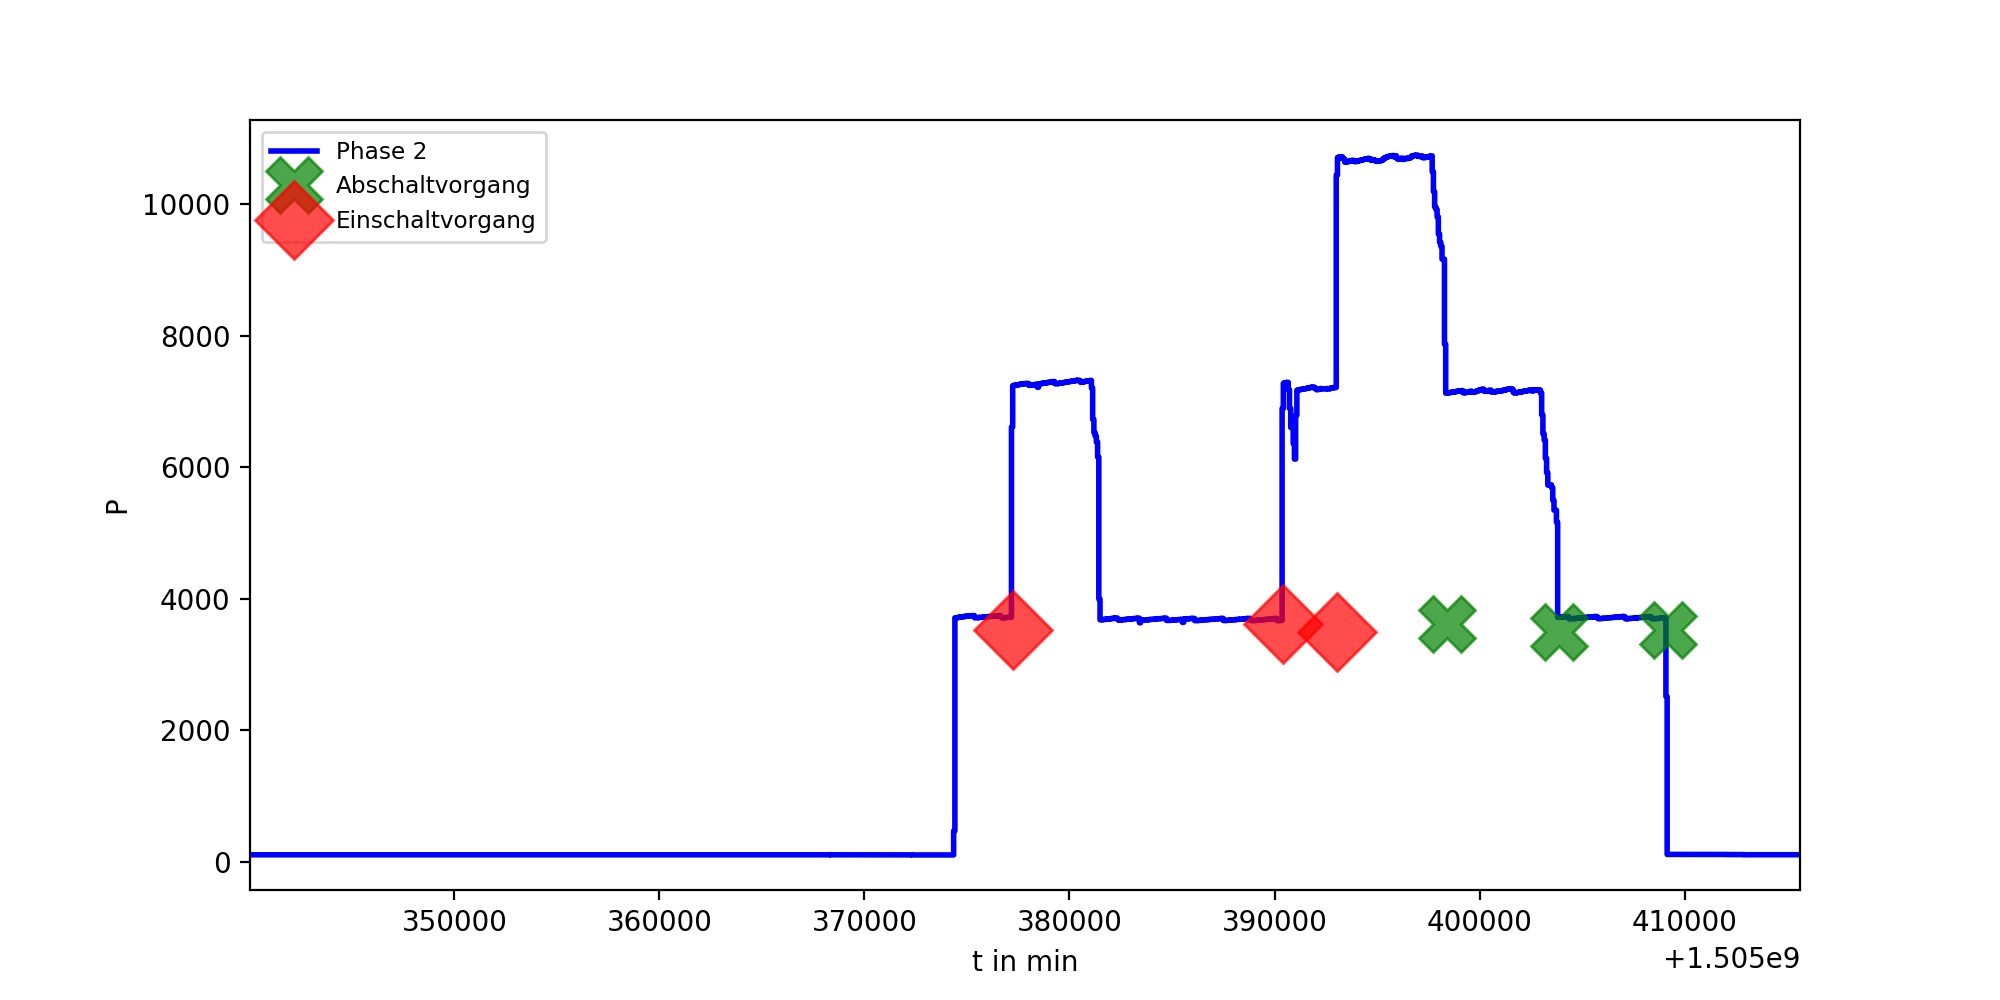

<IPython.core.display.Javascript object>


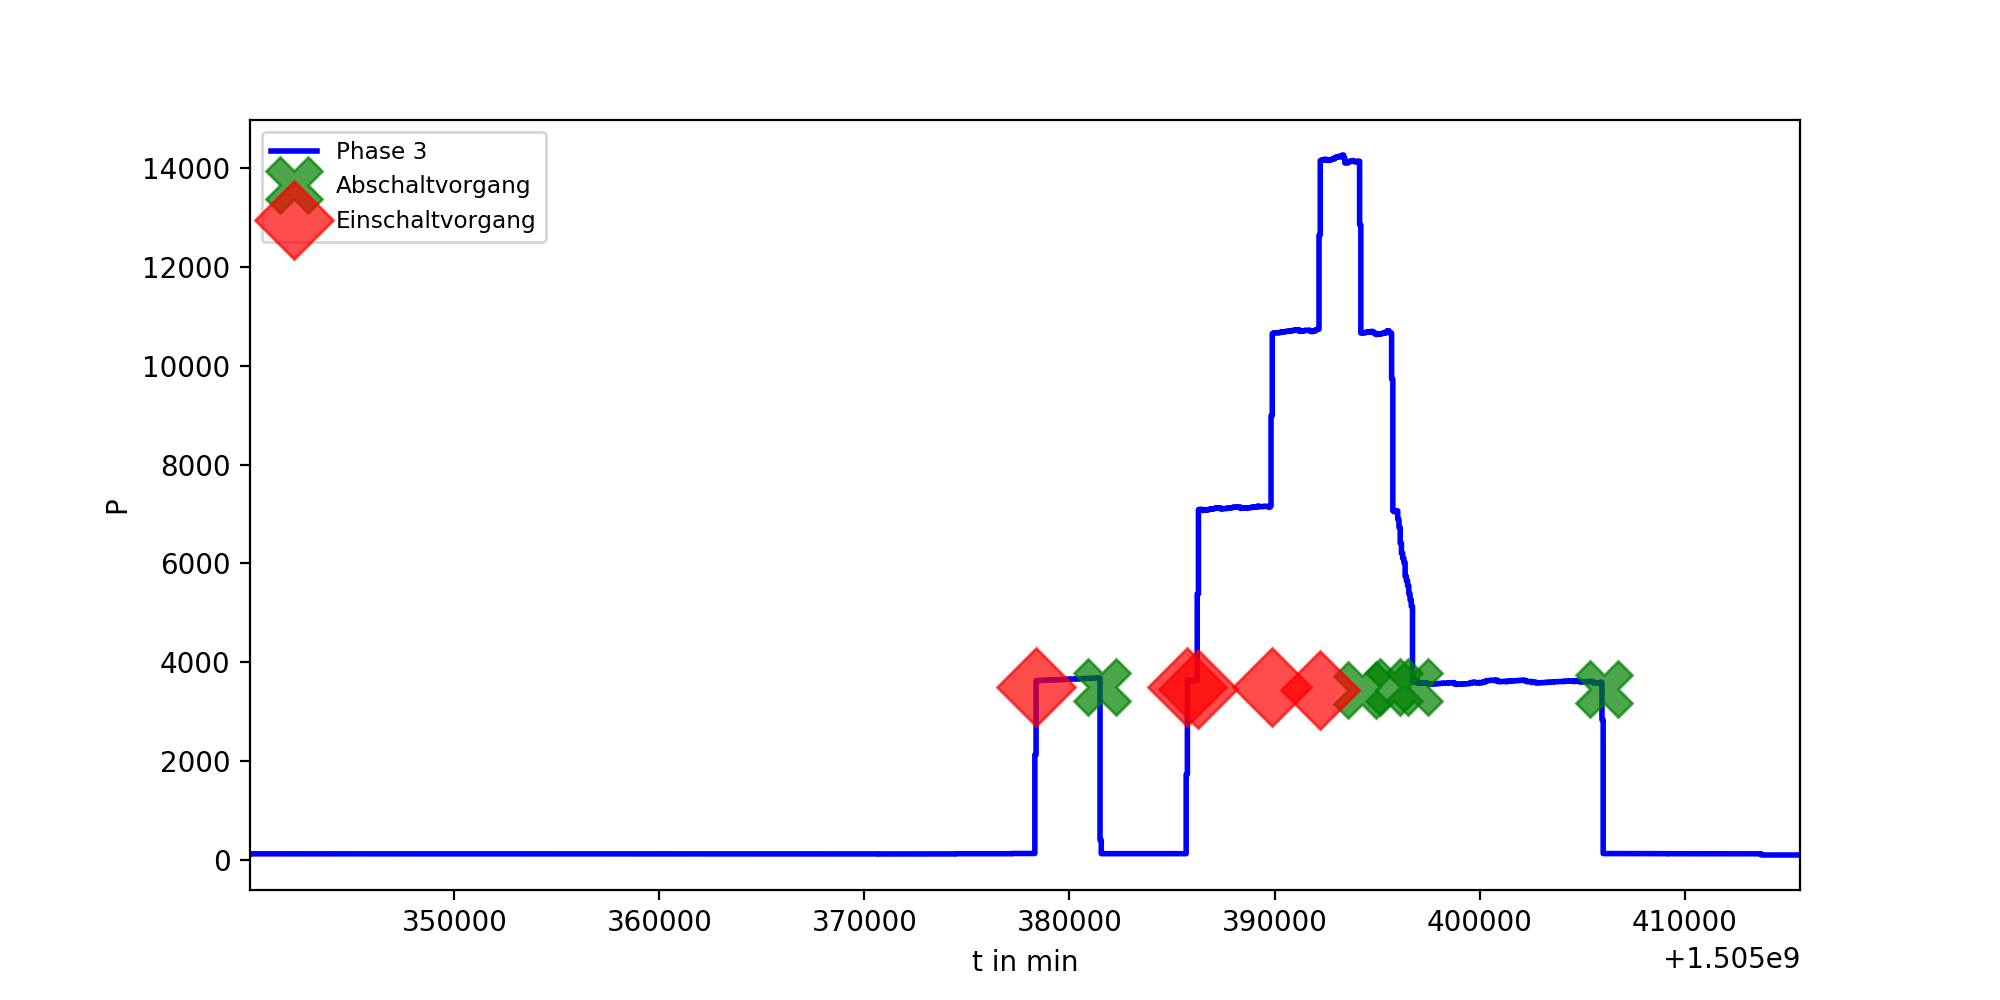

In [7]:
#Plotten aller phasen mit ein und ausschaltvorgang
for Phase in range (1,4):
    Phase_P = pd.read_csv('power_today_minute_'+str(Phase)+'.csv', names = ['timestamp','P'])
    plt.figure(figsize=(10,5))
    plt.step(Phase_P['timestamp'],Phase_P['P'], color="blue", linewidth=2, label='Phase '+str(Phase))
    plt.plot(Event_df[Event_df.Phase == Phase]['timestamp_abschalt'], Event_df[Event_df.Phase == Phase]['Ladeleistung'], "X",color="green", markersize=20,alpha=.7, label='Abschaltvorgang')
    plt.plot(Event_df[Event_df.Phase == Phase]['timestamp'], Event_df[Event_df.Phase == Phase]['Ladeleistung'], "D", color="red", markersize=20,alpha=.7, label='Einschaltvorgang')
    plt.legend(loc='upper left', frameon=True, fontsize = 'small')
    plt.xlim([Phase_mit_delta.iloc[1]['timestamp'],Phase_mit_delta.iloc[len(Phase_mit_delta)-1]['timestamp']])
    plt.ylabel('P')
    plt.xlabel('t in min')